# Characteristic Words

A notebook to explore the distribution of characterising / high frequency / function words in different corpora.

In [1]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import time
from collections import defaultdict
import operator,math
from gensim.models import Word2Vec
import math

import nlp_tools

Functions to find the high frequency (ranked higher than k) distribution for a corpus and display the very highest frequency words (ranked higher than cutoff)

In [2]:
#For a given set of corpora, find the frequency distribution of the k highest frequency words
#Output total size of corpus and sorted list of term, frequency pairs

def find_hfw_dist(corpora,k=100000):
    #add worddicts for individual corpora
    #sort and output highest frequency words
    #visualise
    
    sumdict={}
    corpussize=0
    for acorpus in corpora:
        for(key,value) in acorpus.allworddict.items():
            sumdict[key.lower()]=sumdict.get(key.lower(),0)+value
            corpussize+=value
      
    print("Size of corpus is {}".format(corpussize))
    candidates=sorted(sumdict.items(),key=operator.itemgetter(1),reverse=True)
    #print(candidates[:50])
    #print(len(sumdict))
    #print(sumdict)
    return corpussize,candidates[:k]
        
  

In [3]:
#display the most frequent words in 1 or 2 high frequency word distributions

def display(hfw,cutoff=10,words=[],hfb=None,leg=None):
    width=0.7
    corpussize=hfw[0]
    if words==[]:
        todisplay=hfw[1][:cutoff]
    else:
        todisplay=[(x,y) for (x,y) in hfw[1] if x in words]
        cutoff=len(words)
    barvalues=sorted(todisplay,key=operator.itemgetter(0),reverse=False)
    #print(barvalues)
    xs,ys=[*zip(*barvalues)]
    ps=[y/corpussize for y in ys]
    
    toplot=[ps]
    if hfb!=None:
        width=0.35
        corpussizeb=hfb[0]
        if words==[]:
            todisplayb=hfb[1][:cutoff]
        else:
            todisplayb=[(x,y) for (x,y) in hfb[1] if x in words]
        barb=sorted(todisplayb,key=operator.itemgetter(0),reverse=False)
        
        xb,yb=[*zip(*barb)]
        pb=[y/corpussizeb for y in yb]
        
        toplot.append(pb)
        
    
    N=len(xs)
    ind=np.arange(N)
    fig,ax=plt.subplots(figsize=(cutoff,cutoff/4))
    
    rects1=ax.bar(ind,ps,width,color='r')
    if hfb!=None:
        rects2=ax.bar(ind+width,pb,width,color='b')
        if leg==None:
            ax.legend((rects1,rects2),("Dist1","Dist2"))
        else:
            ax.legend((rects1,rects2),leg)
    ax.set_xticks(ind)
    ax.set_xticklabels(xs)
    ax.set_xlabel('High Frequency Words')
    ax.set_ylabel('Probability')
    
    
    return xs
    


# Differences Between Female and Male Non-Legal Speech in 1800-1820

We are interested in the period 1800-1820.  We are interested in non-legal speech (witness and defendants) in 'theft' trials (which make up the bulk of the trials).  These are split into female and male (by speaker)

In [5]:
p=100
nlp=spacy.load('en')
female_nonlegal=['corpus_1800_1820_theft_f_def','corpus_1800_1820_theft_f_wv']
male_nonlegal=['corpus_1800_1820_theft_m_def','corpus_1800_1820_theft_m_wv']

female_corpus=nlp_tools.corpus(female_nonlegal,nlp,prop=p,ner=False)
male_corpus=nlp_tools.corpus(male_nonlegal,nlp,prop=p,ner=False)

Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 488
Completed 488 docs (10.006151322534345% complete)
Completed 976 docs (20.01230264506869% complete)
Completed 1464 docs (30.018453967603033% complete)
Completed 1952 docs (40.02460529013738% complete)
Completed 2440 docs (50.03075661267172% complete)
Completed 2928 docs (60.03690793520607% complete)
Completed 3416 docs (70.04305925774041% complete)
Completed 3904 docs (80.04921058027476% complete)
Completed 4392 docs (90.05536190280911% complete)
Number of documents is 4877
Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 2228
Completed 2228 docs (10.000897746655895% complete)
Completed 4456 docs (20.00179549331179% complete)
Completed 6684 docs (30.00269323996768% complete)
Completed 8912 docs (40.00359098662358% complete)
Completed 11140 docs (50.004488733279466% complete)
Completed 13368 docs (60.00538647993536% complete)
Completed 15596 docs (70.00628422659126% complete)
Completed 

Lets look at the top 20 most frequent words across the whole corpus (i.e., males and males taken together).

Size of corpus is 1364054


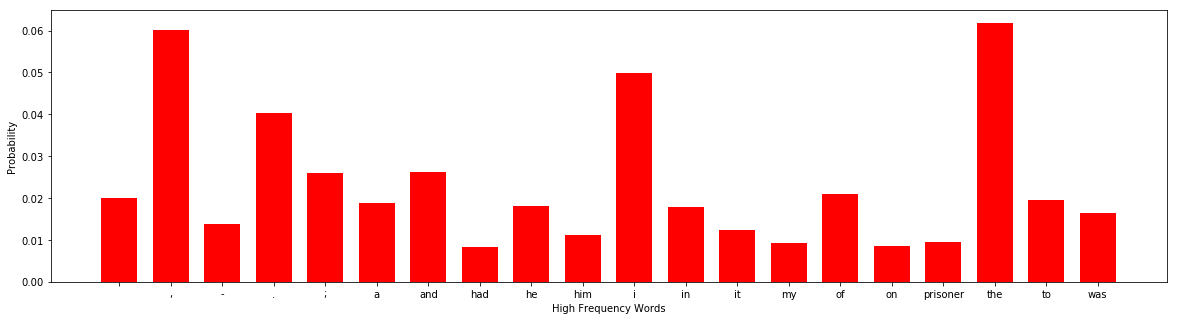

In [6]:
hfw_theft=find_hfw_dist([male_corpus,female_corpus],k=100000)
function_words_theft=display(hfw_theft,cutoff=20)

Now lets compare the distributions of these words for males and females.

Size of corpus is 229558
Size of corpus is 1134496


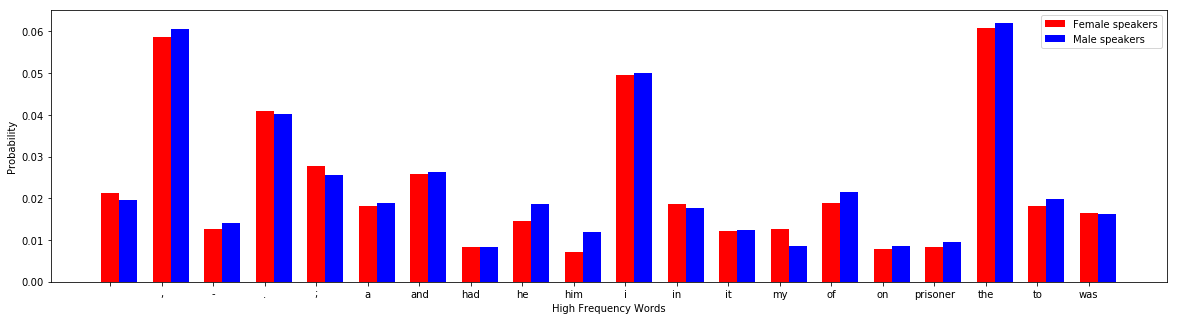

In [7]:
hff_theft=find_hfw_dist([female_corpus])
hfm_theft=find_hfw_dist([male_corpus])
some_words=display(hff_theft,words=function_words_theft,hfb=hfm_theft,leg=['Female speakers','Male speakers'])

There are minimal differences between the distributions. 'of', 'to', 'him','he' and 'the' appear more often for male speakers.  Some punctuation and 'my' appears more often for female speakers.

We want to be able to find the characteristic words for a corpus (i.e., words which occur more often than one would expect by chance).  We can do this using PMI and/or likelihood lift ratio - but it is conventional in work on comparing corpora to use log-likelihood-ratio (LLR (Dunning, 1993)) as this is less biased towards low frequency events than PMI and doesn't require any parameters to be set.

In [11]:
def makedict(alist):
    adict={}
    for (key,value) in alist:
        adict[key]=adict.get(key,0)+value
    return adict
        

def pmi(wordfreq,refwordfreq,corpussize,refcorpussize):
    if wordfreq*refcorpussize*refwordfreq*corpussize==0:
        score=0
#        print(wordfreq,refwordfreq,corpussize,refcorpussize)
    else:
        score=np.log((wordfreq*refcorpussize)/(refwordfreq*corpussize))
    return score


def rev_pmi(wordfreq,refwordfreq,corpussize,refcorpussize):
    return pmi(refwordfreq-wordfreq, refwordfreq,refcorpussize-corpussize,refcorpussize)
        
def llr(wordfreq,refwordfreq,corpussize,refcorpussize):
    #print(wordfreq,refwordfreq,corpussize,refcorpussize)
    mypmi=pmi(wordfreq,refwordfreq,corpussize,refcorpussize)
    myrevpmi=rev_pmi(wordfreq,refwordfreq,corpussize,refcorpussize)
    #myrevpmi2=rev_pmi2(wordfreq,refwordfreq,corpussize,refcorpussize)
    #print(mypmi,myrevpmi,myrevpmi2)
    llr_score=2*(wordfreq*mypmi+(refwordfreq-wordfreq)*myrevpmi)
    if pmi(wordfreq,refwordfreq,corpussize,refcorpussize)<0:
        return -llr_score
    else:
        return llr_score
    
def likelihoodlift(wordfreq,refwordfreq,corpussize,refcorpussize,alpha):
    beta=0
    if alpha==1:
        return math.log(wordfreq/corpussize)
    elif alpha==0:
        return pmi(wordfreq,refwordfreq,corpussize,refcorpussize)
    else:
        return(alpha*math.log(beta+(wordfreq/corpussize))+(1-alpha)*pmi(wordfreq,refwordfreq,corpussize,refcorpussize))

def mysurprise(wf,rwf,cs,rcs,measure,params):
    if measure=='pmi':
        return pmi(wf,rwf,cs,rcs)
    elif measure=='llr':
        return llr(wf,rwf,cs,rcs)
    elif measure =='likelihoodlift':
        return likelihoodlift(wf,rwf,cs,rcs,params.get('alpha',0.5))
    else:
        print("Unknown measure of surprise")

def improved_compute_surprises(corpusA,corpusB,measure,params={}):
    (corpusAsize,wordlistA)=corpusA
    (corpusBsize,wordlistB)=corpusB
    if 'threshold' in params.keys():
        threshold=params['threshold']
    else:
        threshold=len(wordlistA)
    #dictA=makedict(wordlistA)
    dictB=makedict(wordlistB)
    
    scores=[]
   # print(wordlistA[:threshold])
    for(term,freq) in wordlistA[:threshold]:
        scores.append((term,mysurprise(freq,dictB.get(term,freq+1),corpusAsize,corpusBsize,measure,params)))
    sortedscores=sorted(scores,key=operator.itemgetter(1),reverse=True)
    k=200
    print("Top {} terms are ".format(k))
    print(sortedscores[:k])
    rank=0
    if measure=="llr":
        for (term,score) in sortedscores:
            if score>10.828:
                rank+=1
            else:
                break
        print("{} significantly characterising terms".format(rank))
    return(sortedscores[:rank])

We can use the LLR to compute the most characteristic words for males and for females.  Any with a score over 10.828 are statistically significant at the 0.1% level.  We display the top 20.

In [12]:
malewords=improved_compute_surprises(hfm_theft,hfw_theft,'llr')

Top 200 terms are 
[('him', 442.41345870034957), ('his', 247.77749750521707), ('he', 206.13168490977932), ('am', 120.27857259305301), ('horse', 119.3751563997788), ('officer', 108.64030115681004), ('mr.', 101.06793804018218), ('custody', 97.285799304172585), ('produce', 87.890490623532742), ('constable', 86.154282250474409), ('warehouse', 80.68591129094581), ('searched', 76.681281301105855), ('from', 73.52285795469777), ('by', 72.40681987038954), ('apprehended', 68.346152231433365), ('messrs.', 68.009932678737769), ('charge', 67.197441891234945), ('office', 66.954402580793769), ('sheep', 64.313009188703461), ('took', 63.204389881960196), ('clerk', 61.807390502893426), ('of', 60.210455319237667), ('watch', 60.043153234982867), ('lead', 58.189767627411406), ('pigs', 56.01888518387976), ('book', 54.584336398890741), ('yards', 54.134900868249801), ('pocket', 53.195395622472148), ('bag', 50.785337882316227), ('stable', 49.650122040041637), ('watchman', 48.160023550359398), ('hundred', 47.39

In [13]:
femalewords=improved_compute_surprises(hff_theft,hfw_theft,'llr',params={})

Top 200 terms are 
[('she', 1378.6769317520202), ('husband', 1326.1722992681334), ('her', 804.06119645394415), ('room', 383.67579299361728), ('my', 300.64932306616288), ('things', 297.02346878436123), ('stairs', 257.28848971434888), ('mrs.', 222.35574749522294), ('bed', 210.01246078779934), ('mother', 207.44411610896091), ('wife', 200.56508914608366), ('sister', 196.84483870168481), ('gown', 177.73961563817798), ('widow', 163.14080717564579), ('mistress', 161.38503427960887), ('missed', 157.64131411614881), ('door', 146.60052779464883), ('daughter', 141.47340999843641), ('child', 138.51830797502379), ('kitchen', 128.41475077138244), ('lodged', 116.08849941816047), ('woman', 114.05514151478411), ('left', 106.16562681379514), ('came', 100.16310735166235), ('sheet', 97.639169029203785), ('home', 96.834281671150052), ('parlour', 89.53826175401079), ('gowns', 86.139544363421322), ('out', 83.329302094377908), ('cloak', 82.01319282315221), ('weeks', 81.995715176717269), ('counterpane', 81.725

In [14]:
#write to file
femalefile='female_words_llr'
malefile='male_words_llr'
with open(femalefile,'w') as femstream:
    for (term,score) in femalewords:
        femstream.write("{}\t{}\n".format(term,score))
        
with open(malefile,'w') as manstream:
    for(term,score) in malewords:
        manstream.write("{}\t{}\n".format(term,score))

For comparison, we can use the likelihood-lift ratio - however now we need to set alpha to decide the weight of likelihood and lift respectively.

In [15]:
improved_compute_surprises(hfm_theft,hfw_theft,'likelihoodlift',params={'alpha':0.01})

Top 200 terms are 
[('pigs', 0.093251736779198999), ('sheep', 0.090983563412672289), ('co.', 0.089552535072311465), ('skin', 0.088862606357441948), ('timber', 0.088121526635904723), ('stables', 0.08605358250277792), ('mare', 0.08513742292855607), ('post', 0.085012709093228514), ('bridle', 0.084601762404332953), ('pavement', 0.083443444249081733), ('examination', 0.083443444249081733), ('harness', 0.083266448478087729), ('bench', 0.083086263423060927), ('dated', 0.081931134551842491), ('excise', 0.081299345535627177), ('locks', 0.081299345535627177), ('ducks', 0.081079556468439423), ('messrs.', 0.081037666741268555), ('seals', 0.080709755288103688), ('brice', 0.08062493272767185), ('ostler', 0.080389627753569906), ('corresponded', 0.080389627753569906), ('barge', 0.080148652237779311), ('permit', 0.079901726111875584), ('quay', 0.079648548032032696), ('fob', 0.079648548032032696), ('boat', 0.079055675655483854), ('horse', 0.078866920811500971), ('hamper', 0.078848120955297335), ('carrie

[]

In [16]:
improved_compute_surprises(hff_theft,hfw_theft,'likelihoodlift',params={'alpha':0.1})

Top 200 terms are 
[('husband', 0.8302755518323004), ('widow', 0.63518442358665927), ('hians', 0.5774076897431033), ('priestly', 0.54863948249792505), ('fringe', 0.54863948249792505), ('veal', 0.54863948249792505), ('searles', 0.54863948249792505), ('mangle', 0.54591576364773675), ('everitt', 0.53040732681852965), ('stars', 0.53040732681852965), ('pinafore', 0.53040732681852965), ('betty', 0.53040732681852965), ('anne', 0.53040732681852965), ('daughters', 0.53040732681852965), ('willes', 0.50809297168710876), ('errands', 0.50809297168710876), ('thorngate', 0.50809297168710876), ('tippets', 0.50809297168710876), ('pratley', 0.50809297168710876), ('matron', 0.50809297168710876), ('trayner', 0.50809297168710876), ('rau', 0.50809297168710876), ('collard', 0.50809297168710876), ('patient', 0.47932476444193051), ('calverley', 0.47932476444193051), ('lemoine', 0.47932476444193051), ('sad', 0.47932476444193051), ('catlin', 0.47932476444193051), ('weather', 0.47932476444193051), ('barr', 0.4793

[]


## Different Periods Corresponding to Different Scribes


We also have 3 subperiods within the 1800-1820 period which correspond to 3 different scribes / publishers.

In [17]:
p1_nonlegal=['corpus_theft_def_1800_1805','corpus_theft_wv_1800_1805']
p2_nonlegal=['corpus_theft_def_1806_1815','corpus_theft_wv_1806_1815']
p3_nonlegal=['corpus_theft_def_1816_1820','corpus_theft_wv_1816_1820']

p1_corpus=nlp_tools.corpus(p1_nonlegal,nlp,prop=p,ner=False)
p2_corpus=nlp_tools.corpus(p2_nonlegal,nlp,prop=p,ner=False)
p3_corpus=nlp_tools.corpus(p3_nonlegal,nlp,prop=p,ner=False)



Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 1048
Completed 1048 docs (10.008595167605769% complete)
Completed 2096 docs (20.017190335211538% complete)
Completed 3144 docs (30.025785502817303% complete)
Completed 4192 docs (40.034380670423076% complete)
Completed 5240 docs (50.042975838028845% complete)
Completed 6288 docs (60.05157100563461% complete)
Completed 7336 docs (70.06016617324038% complete)
Completed 8384 docs (80.06876134084615% complete)
Completed 9432 docs (90.07735650845191% complete)
Number of documents is 10471
Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 1281
Completed 1281 docs (10.0078125% complete)
Completed 2562 docs (20.015625% complete)
Completed 3843 docs (30.0234375% complete)
Completed 5124 docs (40.03125% complete)
Completed 6405 docs (50.0390625% complete)
Completed 7686 docs (60.046875% complete)
Completed 8967 docs (70.0546875% complete)
Completed 10248 docs (80.0625% complete)
Completed 11529 docs

In [18]:
theft_corpus=nlp_tools.corpus(p1_nonlegal+p2_nonlegal+p3_nonlegal,nlp,prop=p,ner=False)

Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 2845
Completed 2845 docs (10.00281274171999% complete)
Completed 5690 docs (20.00562548343998% complete)
Completed 8535 docs (30.008438225159974% complete)
Completed 11380 docs (40.01125096687996% complete)
Completed 14225 docs (50.014063708599956% complete)
Completed 17070 docs (60.01687645031995% complete)
Completed 19915 docs (70.01968919203995% complete)
Completed 22760 docs (80.02250193375993% complete)
Completed 25605 docs (90.02531467547992% complete)
Number of documents is 28442


In [19]:
def autolabel(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    
    for rect in rects:
        height = rect.get_height()

        ax.text(rect.get_x() + rect.get_width()/2., height*1.1,
                '%1.1f' % height,
                ha='center', va='bottom')

def display_list(hfw_list,cutoff=10,words=[],leg=None,title=None):
    width=0.7/len(hfw_list)
    toplot=[]
    for hfw in hfw_list:
        corpussize=hfw[0]
        if words==[]:
            todisplay=hfw[1][:cutoff]
        else:
            todisplay=[(x,y) for (x,y) in hfw[1] if x in words]
            cutoff=len(words)
        barvalues=sorted(todisplay,key=operator.itemgetter(0),reverse=False)
        #print(barvalues)
        xs,ys=[*zip(*barvalues)]
        ps=[y*100/corpussize for y in ys]
    
        toplot.append(ps)
        
    N=cutoff
    ind=np.arange(N)
    fig,ax=plt.subplots(figsize=(2*cutoff,cutoff/2))
    rectset=[]
    colors=['r','b','y','g']
    for i,ps in enumerate(toplot):
        rectset.append(ax.bar(ind+i*width,ps,width,color=colors[i]))
    
    if leg!=None:
        ax.legend(rectset,leg)
    ax.set_xticks(ind)
    ax.set_xticklabels(xs)
    ax.set_xlabel('High Frequency Words')
    ax.set_ylabel('Probability')
    ax.set_ylim(0,10)
    for rects in rectset:
        autolabel(rects,ax)
    if title!=None:
        ax.set_title(title)
    
    return xs
    


We can look at the high frequency words across the whole corpus (which approximates the male+female combination in the last section - this is slightly larger, due presumably to some utterances not being labelled as either female or male).

Size of corpus is 1437948


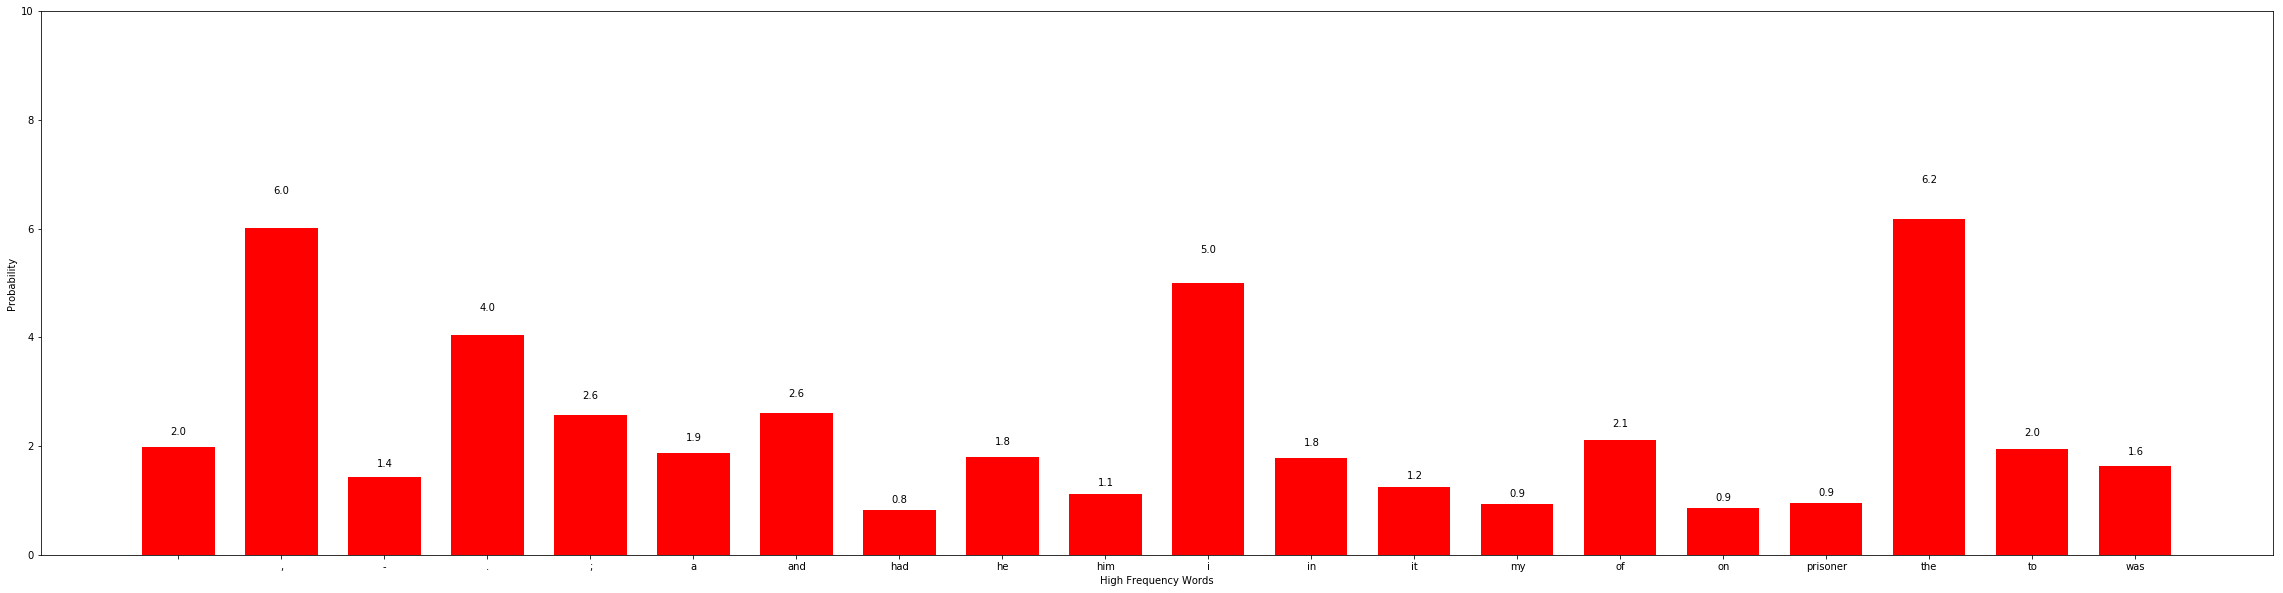

In [20]:
k=100000
hfperiods_theft=find_hfw_dist([p1_corpus,p2_corpus,p3_corpus],k=k)
function_words_theft=display_list([hfperiods_theft],cutoff=20)

Size of corpus is 457201
Size of corpus is 645170
Size of corpus is 335577


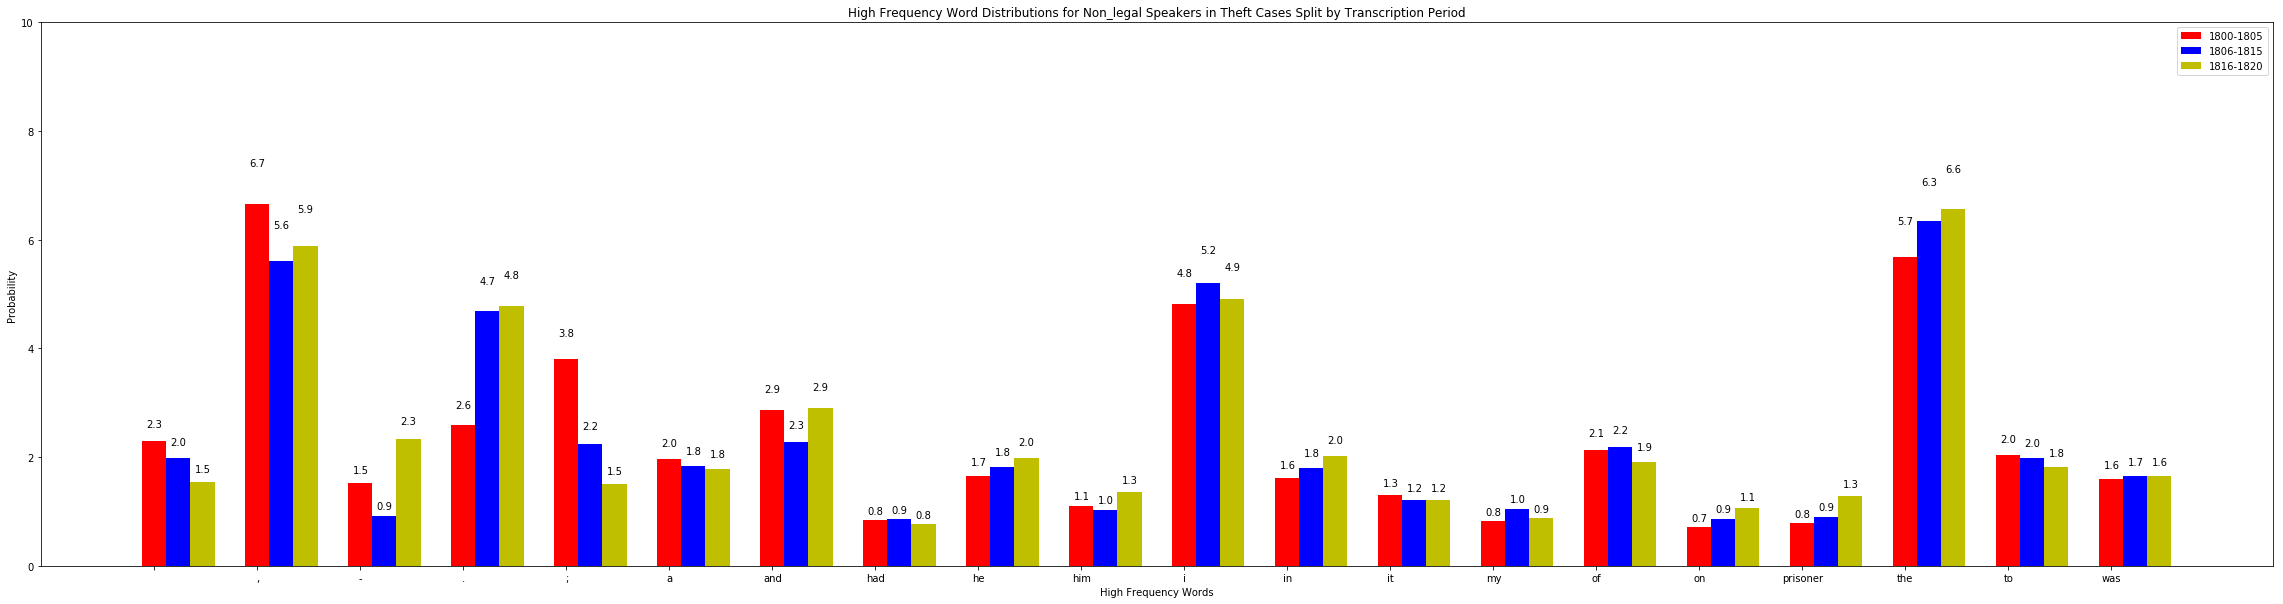

In [21]:

hfp1_theft=find_hfw_dist([p1_corpus],k=k)
hfp2_theft=find_hfw_dist([p2_corpus],k=k)
hfp3_theft=find_hfw_dist([p3_corpus],k=k)
some_words=display_list([hfp1_theft,hfp2_theft,hfp3_theft],words=function_words_theft,leg=['1800-1805','1806-1815','1816-1820'],title="High Frequency Word Distributions for Non_legal Speakers in Theft Cases Split by Transcription Period")

Comparing the different corpora, we see that there is a much greater use of ; in the first period and correspondingly, a greater use of . in the later periods.  We also see an increasing use of 'the' throughout the 3 periods and a corresponding decreasing use of 'a'.

In [22]:
p1words=improved_compute_surprises(hfp1_theft,hfperiods_theft,'llr')

Top 200 terms are 
[(';', 3736.4459269388681), (':', 1458.3110734165061), (')', 535.47959448109157), ('produces', 530.32124722672199), ('yes', 515.21522455675699), ('upon', 496.84528575502861), (',', 465.13217105454351), ('but', 426.45499019329975), ('(', 423.54348473500437), ('\n', 322.17064959274239), ('no', 258.00405378714368), ('and', 163.73581618256003), ('can', 158.97184658715787), ('very', 142.91152194763004), ('identified', 130.08427272509815), ('then', 124.25862856385481), ("n't", 120.89555955690639), ('till', 118.54000666498337), ('warehouses', 93.409897803113921), ('say', 89.595204090119978), ('not', 81.4050756633834), ('mr.', 78.009115488388602), ('deposed', 77.917749486003274), ('letters', 73.68320582164344), ('aslett', 71.042653943120641), ('belonging', 61.802438445077328), ('lying', 61.613630307425815), ('jennings', 59.584161371649564), ('or', 58.41762074071454), ('guinea', 57.534001655679816), ('broke', 56.440430401385626), ('bar', 55.941445826758894), ('same', 51.64992

In [23]:
p2words=improved_compute_surprises(hfp2_theft,hfperiods_theft,'llr')

Top 200 terms are 
[('.', 1188.2542208353316), ('that', 595.63791351958457), ('this', 361.16105063123439), ('watchhouse', 361.04109272201583), ('shillings', 325.25121290530706), ('pound', 323.71231016977401), ('these', 232.74063307056878), ('is', 186.85639452039993), ('until', 150.56950296369607), ('my', 145.97370780803021), ('skins', 145.01423064631334), ('are', 140.78725933345993), ('march', 109.3731415084502), ('..', 93.444239496933136), ('produce', 92.842213932836671), ('22nd', 86.199168500444273), ('i', 82.815135019869103), ('catched', 80.24963560620354), ('pounds', 80.171227216870506), ('they', 77.863989237244141), ('she', 76.3577474730007), ('2nd', 69.617574747120486), ('pawned', 67.43958886237742), ('all', 62.669575075207717), ('pence', 57.618724291540914), ('ratcliffe', 57.459119144001207), ('woman', 57.192554783466591), ('pieces', 56.989980272720942), ('halfpence', 55.110347114912358), ('throwed', 54.499179926583466), ('3rd', 51.787412309749499), ('shop', 49.114676209197683),

In [24]:
p3words=improved_compute_surprises(hfp3_theft,hfperiods_theft,'llr')

Top 200 terms are 
[('-', 2218.0077723870936), ('"', 897.47385030298506), ("o'clock", 571.71368170996516), ('.', 560.14901117095906), ('prisoner', 472.59994468538116), ('who', 429.13253345921351), ('secured', 393.84235088512639), ('live', 341.30685631712868), ('lives', 337.4935415771248), ('am', 335.49799739583023), ('?', 327.67370675460268), ('1l', 292.29101157895519), ('on', 202.67414144859981), ('pledged', 200.74821570966822), ('!', 198.11085779105562), ('him', 197.28599797597803), ('found', 186.73164560047496), ('july', 181.08350651068807), ('stated', 176.87225265908256), ('6d', 176.71512203767855), ('about', 168.59043575793567), ('ran', 160.15444276203664), ('which', 159.22046451565245), ('and', 140.92894519343963), ('s.', 129.48534416747788), ('august', 129.1025762556294), ('in', 127.10125684766263), ('prosecutor', 123.18297272962218), ('3s', 116.36568345384748), ('5l', 103.45699293677632), ('missed', 101.96463330007248), ('the', 99.76374786791348), ('l.', 88.742444693686338), ('

## Analysis of Characterising Terms

Having derived a set of characterising terms for a subcorpus, we want to analyse them.  Basic analysis includes average frequency and POS tag distribution.  Further analysis includes clustering semantically.



In [25]:
def autolabel(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    
    for rect in rects:
        height = rect.get_height()

        ax.text(rect.get_x() + rect.get_width()/2., height*1.1,
                '%1.1f' % height,
                ha='center', va='bottom')
        
def improved_display_list(xvalues,yvalueslist,labels={}):
    width=0.7/len(yvalueslist)      
    N=len(xvalues)
    ind=np.arange(N)
    fig,ax=plt.subplots(figsize=(20,12))
    rectset=[]
    colors=['r','b','y','g']
    for i,ps in enumerate(yvalueslist):
        rectset.append(ax.bar(ind+i*width,ps,width,color=colors[i]))
    
    leg=labels.get('leg',None)
    title=labels.get('title',None)
    xlabel=labels.get('xlabel','Year')
    ylabel=labels.get('ylabel','Probability')
    ylim=labels.get('ylim',1)
    if leg!=None:
        ax.legend(rectset,leg)
    ax.set_xticks(ind)
    ax.set_xticklabels(xvalues)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0,ylim)
    for rects in rectset:
        autolabel(rects,ax)
    if title!=None:
        ax.set_title(title)
    plt.show()

In [26]:
#We have a corpus e.g., male_corpus and a set of characterising terms for that corpus e.g., malewords
def find_pos(term,corpus):
    pospos=['NOUN','VERB','ADJ','ADV','PUNCT']
    counts={}
    for apos in pospos:
        counts[apos]=corpus.wordposdict.get((term,apos),0)
    
    total=sum(counts.values())
    
    gt=corpus.allworddict.get(term,0)
    counts['OTHER']=gt-total
    #print(term,gt,counts)
    if gt>0:
        poses=[(tag,weight/gt) for (tag,weight) in counts.items()]
    else:
        poses=[]
    #print(term,poses)
    return poses
    
def analyse(termset,corpus):
    freqs=[]
    somefreqs=[]
    posdict={}
    someposdict={}
    threshold=20
    for i,(term,relevance) in enumerate(termset):
        freq=corpus.allworddict[term]
        freqs.append(freq)
        if i<threshold:
            somefreqs.append(freq)
        poses=find_pos(term,corpus)
        for mypos,weight in poses:
            posdict[mypos]=posdict.get(mypos,0)+weight
            if i<threshold:
                someposdict[mypos]=someposdict.get(mypos,0)+weight
            
        
    freqarray=np.array(freqs)    
    meanfreq=np.mean(freqarray)
    sdfreq=np.std(freqarray)
    meanprob=meanfreq/corpus.wordtotal
    sdprob=sdfreq/corpus.wordtotal
    print("Mean frequency is {}, sd is {}".format(meanfreq,sdfreq))
    print("Mean probability is {}, sd is {}".format(meanprob,sdprob))
    somefreqarray=np.array(somefreqs)
    meansomefreq=np.mean(somefreqarray)
    sdsomefreq=np.std(somefreqarray)
    meansomeprob=meansomefreq/corpus.wordtotal
    sdsomeprob=sdsomefreq/corpus.wordtotal
    print("For top {} words, mean freq is {}, sd is {}".format(threshold,meansomefreq,sdsomefreq))
    print("For top {} words, mean prob is {}, sd is {}".format(threshold,meansomeprob,sdsomeprob))
    #print(posdict)
    xvalues=posdict.keys()
    totaly=sum(posdict.values())
    totalz=sum(someposdict.values())
    allvalues=[]
    somevalues=[]
    for x in xvalues:
        allvalues.append(posdict.get(x,0))
        somevalues.append(someposdict.get(x,0))
    yvalues=[[100*y/totaly for y in allvalues],[100*z/totalz for z in somevalues]]
    labels={'title':'Distribution of POS in Characterising Terms','xlabel':'Part of Speech','ylabel':'Proportion','leg':['Whole Set',"Top {}-restricted Set".format(threshold)],'ylim':100}
    improved_display_list(xvalues,yvalues,labels)

Mean frequency is 1494.8835341365461, sd is 6578.963647962712
Mean probability is 0.0010395949882308303, sd is 0.0045752444789121105
For top 20 words, mean freq is 4346.0, sd is 6293.400034957257
For top 20 words, mean prob is 0.0030223624220069153, sd is 0.004376653422068988


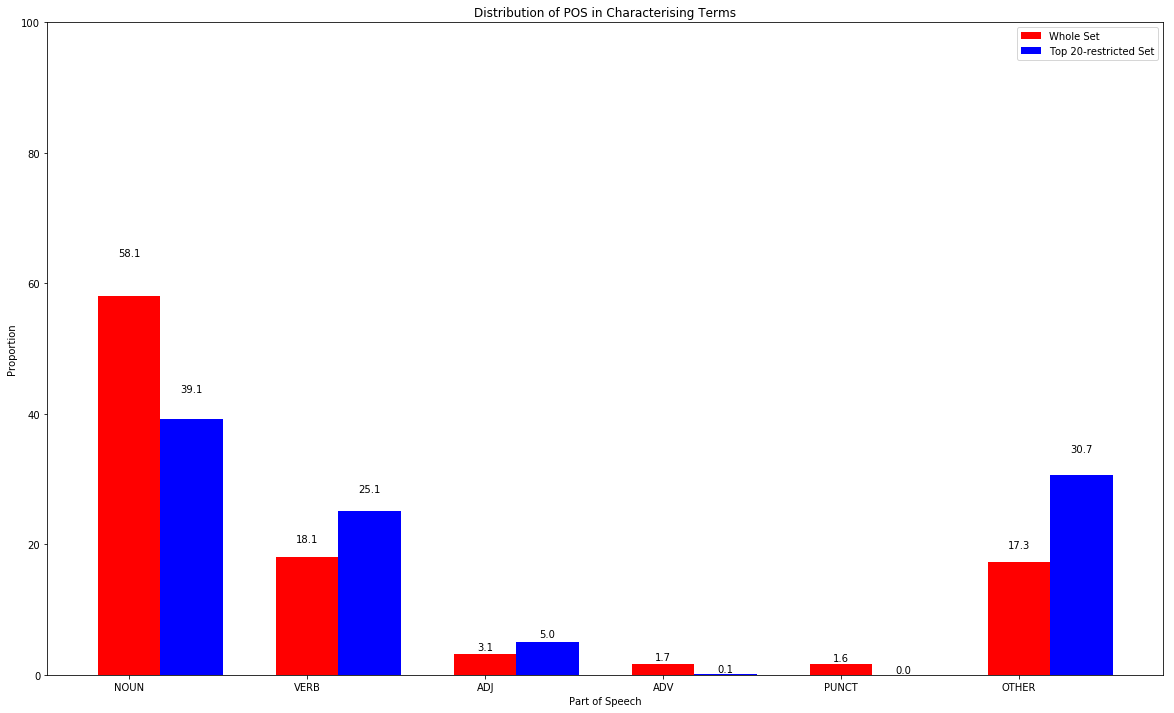

In [27]:
analyse(malewords,theft_corpus)

Mean frequency is 1115.9570815450643, sd is 3498.7043264361796
Mean probability is 0.0007760761039655567, sd is 0.0024331229824974057
For top 20 words, mean freq is 2177.15, sd is 3284.9888473935493
For top 20 words, mean prob is 0.0015140672680792353, sd is 0.0022844976643060454


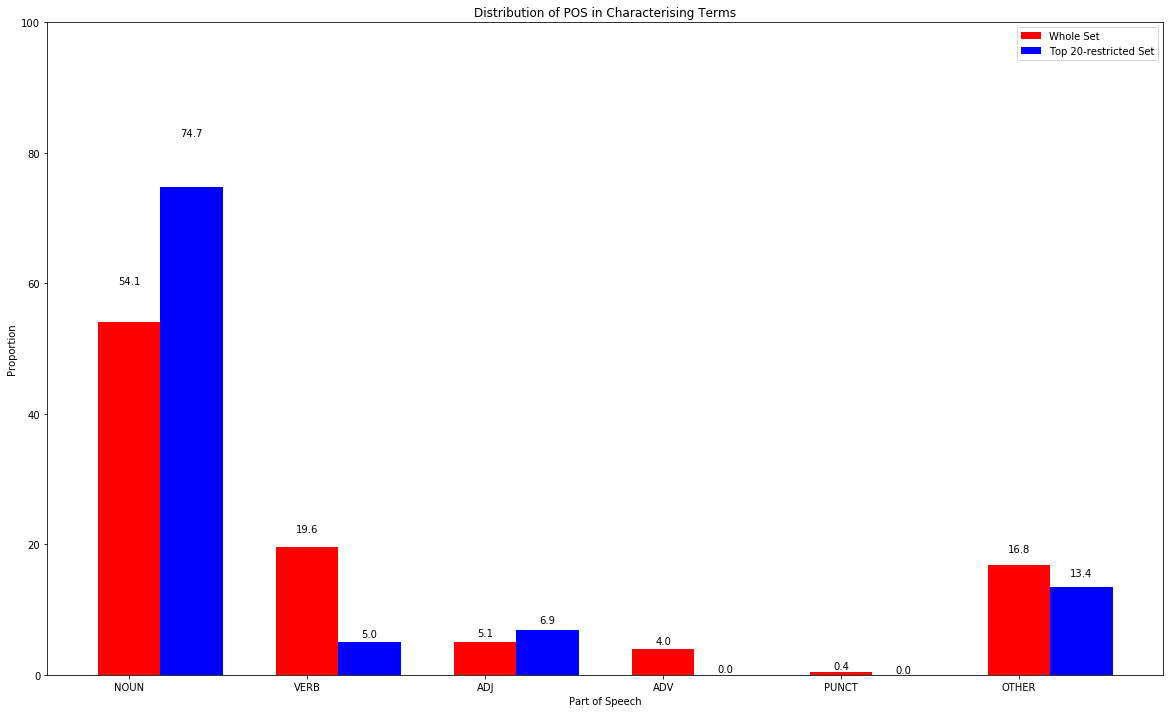

In [28]:
analyse(femalewords,theft_corpus)

Mean frequency is 1228.8291139240507, sd is 6453.708184077455
Mean probability is 0.0008545713154606778, sd is 0.004488137390279381
For top 20 words, mean freq is 10741.85, sd is 20985.234783711614
For top 20 words, mean prob is 0.007470263180587893, sd is 0.014593875984188312


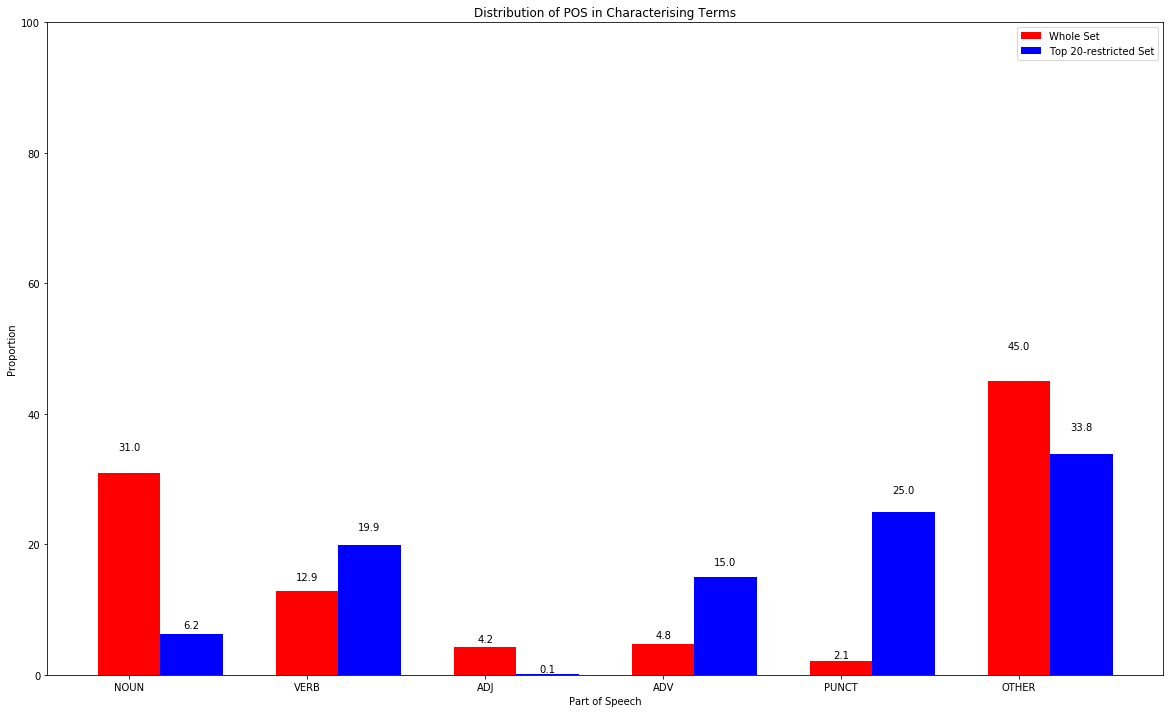

In [29]:
analyse(p1words,theft_corpus)

Mean frequency is 1343.5454545454545, sd is 7551.381061087571
Mean probability is 0.0009343491242697612, sd is 0.005251498010420106
For top 20 words, mean freq is 8691.15, sd is 19224.024917469807
For top 20 words, mean prob is 0.006044133723889876, sd is 0.013369068226020556


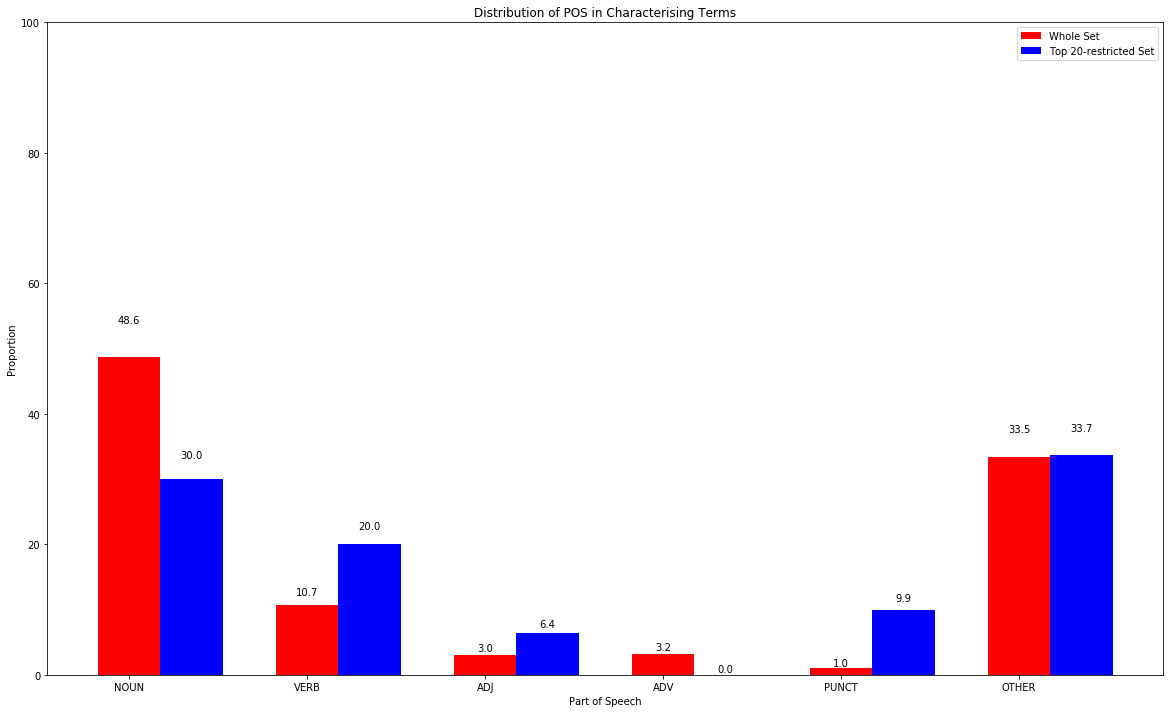

In [30]:
analyse(p2words,theft_corpus)

Mean frequency is 1142.0074074074073, sd is 6129.372850720945
Mean probability is 0.0007941924237923814, sd is 0.004262583105036444
For top 20 words, mean freq is 7270.6, sd is 13167.25150667367
For top 20 words, mean prob is 0.005056232909674063, sd is 0.00915697334442808


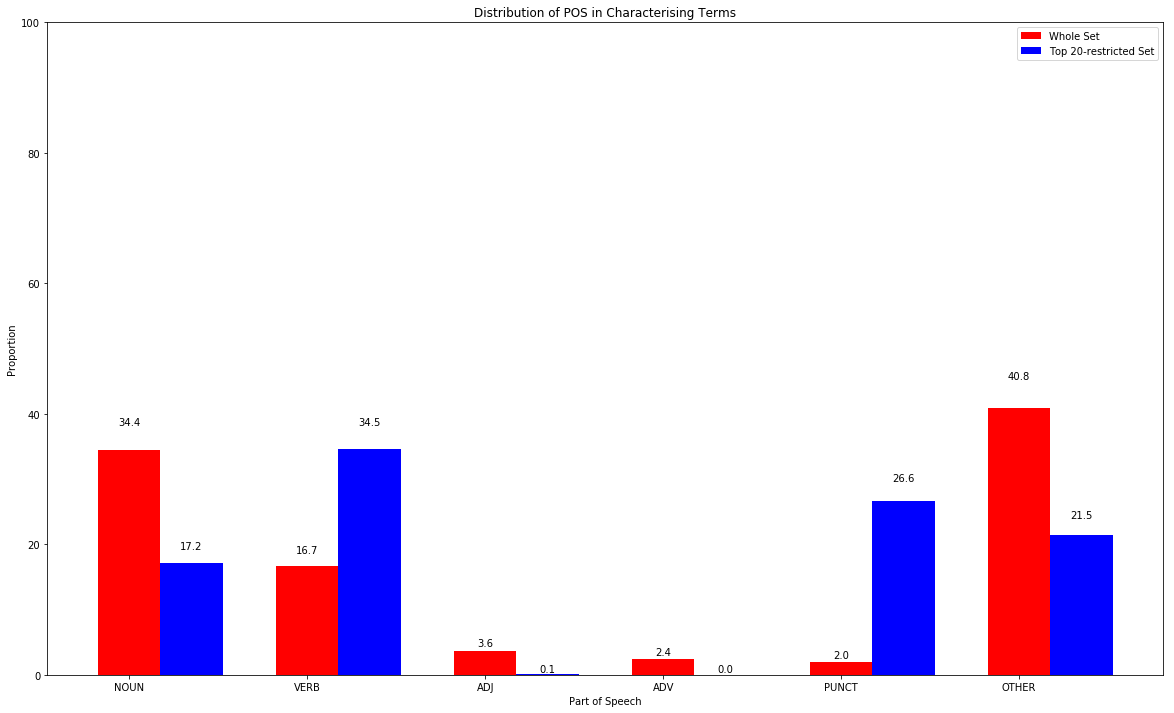

In [31]:
analyse(p3words,theft_corpus)

We can see that a much higher percentage of the characteristic words in the period corpora are punctuation and function words.  In the male/female splits, a higher percentage of the characteristic words are content words.  Looking at the most characterising words, it seems that there may be more characteristic nouns for females and more characteristic verbs for males but this would need further exploration.

## Word2Vec clustering


In [32]:
#from gensim.models import Word2Vec

#parameters
size=300
min_count=10
window=1
sg=1 #1=use skip-gram, otherwise=cbow

In [33]:
start=time.time()
theft_model=Word2Vec(theft_corpus.sentences,min_count=min_count,window=window,size=size,sg=sg,workers=4)
vocab=list(theft_model.wv.vocab.keys())
print("Word2Vec model built with example vocabulary:")
print(str(vocab[0:10]))
end=time.time()
print("Time taken: {}s".format(str(end-start)))

Word2Vec model built with example vocabulary:
['i', 'never', 'saw', 'the', 'woman', 'in', 'my', 'life', '.', '\n']
Time taken: 8.058069944381714s


In [34]:
theft_model.wv.most_similar(['.'])

[('..', 0.7483799457550049),
 ('?', 0.6416943669319153),
 ('....', 0.606925904750824),
 ('\n', 0.543373703956604),
 ('a.', 0.5359265208244324),
 ('whilst', 0.45298704504966736),
 ('it.\\', 0.45258617401123047),
 ('attacked', 0.45245760679244995),
 ('amounting', 0.4468768537044525),
 ('aged', 0.4464248716831207)]

In [35]:
theft_model.wv.most_similar(['prisoner'])

[('defendant', 0.6731184720993042),
 ('prosecutrix', 0.641255259513855),
 ('prosecutor', 0.629448652267456),
 ('langley', 0.5996298789978027),
 ('limbrick', 0.5777304172515869),
 ('lad', 0.5749109387397766),
 ('wyegate', 0.5744865536689758),
 ('gentleman', 0.5742286443710327),
 ('bar', 0.5715653300285339),
 ('lobby', 0.5697882175445557)]

In [36]:
theft_model.wv.most_similar(['warehouse'])

[('stable', 0.8068810105323792),
 ('pantry', 0.8059081435203552),
 ('passage', 0.7798969745635986),
 ('loft', 0.7754330039024353),
 ('brewhouse', 0.7533169388771057),
 ('cellar', 0.7507472038269043),
 ('garret', 0.748918890953064),
 ('bedroom', 0.7483941316604614),
 ('parlour', 0.7482156157493591),
 ('kitchen', 0.7450332641601562)]

In [37]:
theft_model.wv.most_similar(['husband'])

[('mother', 0.8049662113189697),
 ('father', 0.8024923801422119),
 ('sister', 0.799789547920227),
 ('mistress', 0.7970733642578125),
 ('daughter', 0.7930319309234619),
 ('aunt', 0.759781539440155),
 ('son', 0.728303074836731),
 ('master', 0.7273372411727905),
 ('uncle', 0.7141318321228027),
 ('cousin', 0.7132224440574646)]

In [38]:
def nearest_neighbours(wordset,w2vmodel):
    threshold=20
    found=0
    for i,(term,score) in enumerate(wordset):
        try:
            neighbours=w2vmodel.wv.most_similar([term])
            found+=1
            if i<threshold:
                print(term,neighbours)
        except:
            print("{} not in vocab".format(term))
    
    oov=100-(found*100/len(wordset))
    print("Out of vocabulary: {}".format(oov))
    
    

In [39]:
nearest_neighbours(femalewords,theft_model)

she [('he', 0.7412221431732178), ('moody', 0.5938887596130371), ('defendant', 0.5764707326889038), ('they', 0.567938506603241), ('readily', 0.5654587149620056), ('bligh', 0.5613709688186646), ('formerly', 0.5552041530609131), ('provided', 0.5526620149612427), ('unless', 0.551141083240509), ('husband', 0.5498078465461731)]
husband [('mother', 0.8049662113189697), ('father', 0.8024923801422119), ('sister', 0.799789547920227), ('mistress', 0.7970733642578125), ('daughter', 0.7930319309234619), ('aunt', 0.759781539440155), ('son', 0.728303074836731), ('master', 0.7273372411727905), ('uncle', 0.7141318321228027), ('cousin', 0.7132224440574646)]
her [('him', 0.6446456909179688), ('herself', 0.5729403495788574), ('langley', 0.5363460779190063), ('me', 0.5336166024208069), ('prisoners', 0.5332859754562378), ('bulky', 0.5276264548301697), ('us', 0.5256074666976929), ('his', 0.5199295282363892), ('refused', 0.5155174732208252), ('bail', 0.5148798227310181)]
room [('kitchen', 0.7410447597503662),

In [40]:
nearest_neighbours(malewords,theft_model)

him [('me', 0.7047571539878845), ('her', 0.6446456909179688), ('us', 0.6299777030944824), ('langley', 0.6281955242156982), ('resisted', 0.5932115316390991), ('inquired', 0.5854138135910034), ('bail', 0.5768976211547852), ('rayson', 0.5717211961746216), ('meant', 0.5698522329330444), ('presently', 0.5696577429771423)]
his [('their', 0.687963604927063), ('your', 0.6789782047271729), ('my', 0.6278635263442993), ('hid', 0.5426934361457825), ('repair', 0.5303051471710205), ('its', 0.5267015695571899), ('pretence', 0.525867223739624), ('prisoners', 0.5251446962356567), ('her', 0.5199294686317444), ('holding', 0.5131368637084961)]
he [('she', 0.7412221431732178), ('moody', 0.635277509689331), ('defendant', 0.618132472038269), ('bligh', 0.6115201711654663), ('they', 0.597185492515564), ("ma'am", 0.5885469913482666), ('tom', 0.5825900435447693), ('brice', 0.5823519229888916), ('probably', 0.5740911364555359), ('jack', 0.5704175233840942)]
am [('journeyman', 0.569075345993042), ('entire', 0.5568

In [41]:
nearest_neighbours(p1words,theft_model)

; [(':', 0.6661173701286316), (',', 0.6037898063659668), ('untill', 0.5795877575874329), ('whilst', 0.5757938623428345), ('bligh', 0.5539565086364746), ('wyegate', 0.5455580353736877), ('moody', 0.5437320470809937), ('accordingly', 0.5362878441810608), ('persisted', 0.5331149101257324), ('joined', 0.5306950211524963)]
: [(';', 0.6661173701286316), (',', 0.5398867130279541), ('....', 0.5023549795150757), ('..', 0.4936864376068115), ('friday', 0.48981791734695435), ('may.', 0.4823756814002991), ('preceding', 0.47902679443359375), ('barry', 0.46966326236724854), ('thursday', 0.46813246607780457), ('wednesday', 0.4676532745361328)]
) [('producing', 0.7305973172187805), ('identified', 0.712422251701355), ('produces', 0.6928706169128418), ('repeating', 0.6726940870285034), ('claimed', 0.6571785807609558), ('produced', 0.6293554306030273), ('read', 0.6275597810745239), ('(', 0.6267099380493164), ('redeemed', 0.6072431802749634), ('....', 0.5752847194671631)]
produces [('producing', 0.92765915

In [42]:
nearest_neighbours(p2words,theft_model)

. [('..', 0.7483799457550049), ('?', 0.6416943669319153), ('....', 0.606925904750824), ('\n', 0.543373703956604), ('a.', 0.5359265208244324), ('whilst', 0.45298704504966736), ('it.\\', 0.45258617401123047), ('attacked', 0.45245760679244995), ('amounting', 0.4468768537044525), ('aged', 0.4464248716831207)]
that [('which', 0.5919324159622192), ('wrong', 0.5405300855636597), ('whoever', 0.5348094701766968), ('whether', 0.5247097015380859), ('persisted', 0.5230268836021423), ('whom', 0.5180702209472656), ('because', 0.5108938813209534), ('drunken', 0.5094345211982727), ('most', 0.5082739591598511), ('unless', 0.5060873627662659)]
this [('the', 0.5042591094970703), ('identical', 0.4996032118797302), ('third', 0.4971873164176941), ('another', 0.49467065930366516), ('canvas', 0.48612695932388306), ('second', 0.4795188307762146), ('that', 0.4775157570838928), ('butter', 0.4753057360649109), ('hunting', 0.46675848960876465), ('print', 0.463672399520874)]
watchhouse [('compter', 0.90013378858566

In [43]:
nearest_neighbours(p3words,theft_model)

- [('lion', 0.519591748714447), ('cross', 0.5161571502685547), ('upper', 0.5052181482315063), ('square', 0.5017600059509277), ('falcon', 0.49804267287254333), ('red', 0.4940197467803955), ('cannon', 0.48661667108535767), ('cow', 0.48359420895576477), ('market', 0.47837620973587036), ('row', 0.478060781955719)]
" [('certainly', 0.6733809113502502), ('forgiveness', 0.662676990032196), ('pray', 0.6494996547698975), ('now', 0.6272869110107422), ("ma'am", 0.6195505857467651), ('fact', 0.6116979122161865), ('voluntarily', 0.611389696598053), ('affair', 0.6093842387199402), ('devil', 0.6082282662391663), ('oh', 0.6038591861724854)]
o'clock [('dials', 0.6945585012435913), ('forenoon', 0.6931767463684082), ('afternoon', 0.6918802261352539), ('noon', 0.6678977012634277), ('nights', 0.6624467968940735), ('bells', 0.6602736115455627), ('evening', 0.6466845273971558), ('awoke', 0.6371479034423828), ('waked', 0.6361234188079834), ('sows', 0.6346038579940796)]
. [('..', 0.7483799457550049), ('?', 0.6

In [44]:
theft_model.wv.similarity('man','woman')

0.83225894546770152

In [45]:
def make_matrix(wordset,model,threshold=0.5):
    
    matrix=[]
    
    for (termA,_score) in wordset:
        row=[]
        for(termB,_score) in wordset:
            try:
                sim=model.wv.similarity(termA,termB)
                if sim<threshold:
                    sim=0
            except:
                sim=0
            row.append(sim)
            
        matrix.append(row)
    return matrix

In [46]:
female_matrix=make_matrix(femalewords,theft_model)

In [47]:
import csv

punctdict={"\n":"_NEWLINE",";":"_SEMICOLON",":":"_COLON","\"":"_QUOTE","'s":"_GEN","-":"_HYPHEN","(":"_LEFTBRACKET",")":"_RIGHTBRACKET",",":"_COMMA",".":"_FULLSTOP","..":"_DOTDOT"}

def clean(term):
    
    #remove punctuation which will confuse Gephi
    cleanterm=punctdict.get(term,term)
    return cleanterm

def make_csv(wordset,model,filename):
    matrix=make_matrix(wordset,model)
    terms=[clean(term) for (term,score) in wordset]
    
    #with open(filename,'w') as csvfile:
    #    csvwriter=csv.writer(csvfile,dialect='excel')
    #    headings=['']+terms
        #print(headings)
    #    csvwriter.writerow(headings)
    #    for term,row in zip(terms,matrix):
    #        csvwriter.writerow([term]+row)
     
    with open(filename,'w') as csvfile:
        line=""
        for term in terms:
            line+=';'+term
        line+='\n'
        
        csvfile.write(line)
        #print(line)
        for term,row in zip(terms,matrix):
            line=term
            #print(row)
            for item in row:
                line+=';'+str(item)
                
            line+='\n'
            
            csvfile.write(line)
            #print(line) 
    

In [48]:
make_csv(femalewords,theft_model,'matrix_female.csv')

In [49]:
make_csv(malewords,theft_model,'matrix_male.csv')

In [50]:
make_csv(p1words,theft_model,'matrix_p1.csv')

In [51]:
make_csv(p2words,theft_model,'matrix_p2.csv')

In [52]:
make_csv(p3words,theft_model,'matrix_p3.csv')

In [53]:
print(malewords)

[('him', 442.41345870034957), ('his', 247.77749750521707), ('he', 206.13168490977932), ('am', 120.27857259305301), ('horse', 119.3751563997788), ('officer', 108.64030115681004), ('mr.', 101.06793804018218), ('custody', 97.285799304172585), ('produce', 87.890490623532742), ('constable', 86.154282250474409), ('warehouse', 80.68591129094581), ('searched', 76.681281301105855), ('from', 73.52285795469777), ('by', 72.40681987038954), ('apprehended', 68.346152231433365), ('messrs.', 68.009932678737769), ('charge', 67.197441891234945), ('office', 66.954402580793769), ('sheep', 64.313009188703461), ('took', 63.204389881960196), ('clerk', 61.807390502893426), ('of', 60.210455319237667), ('watch', 60.043153234982867), ('lead', 58.189767627411406), ('pigs', 56.01888518387976), ('book', 54.584336398890741), ('yards', 54.134900868249801), ('pocket', 53.195395622472148), ('bag', 50.785337882316227), ('stable', 49.650122040041637), ('watchman', 48.160023550359398), ('hundred', 47.395880821068005), ('f

In [54]:
theft_lexicon=makedict(hfperiods_theft[1])
p1theft_lexicon=makedict(hfp1_theft[1])

In [55]:
def lookup(term,d1,d2):
    lex1=makedict(d1[1])
    lex2=makedict(d2[1])
    print('{}:{},{}'.format(term,lex1[term],lex2[term]))

In [56]:
lookup('fork',hfperiods_theft,hfp1_theft)

fork:15,12


In [57]:
lookup('drawer',hfw_theft,hff_theft)

drawer:244,89
